In [92]:
import pandas as pd
import detect_sleep_states.evaluation 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train_series = pd.read_parquet('data/train_series.parquet')
# train_series["timestamp"] = pd.to_datetime(train_series["timestamp"] )

In [3]:
train_events = pd.read_csv('data/train_events.csv')
# train_events["timestamp"] = pd.to_datetime(train_events["timestamp"] )

In [ ]:
test_series = pd.read_parquet('data/test_series.parquet')

sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
train_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0.0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1.0,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2.0,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3.0,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4.0,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375.0,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376.0,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377.0,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378.0,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [6]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14505,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14506,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14507,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14508,fe90110788d2,35,onset,NaN,NaN


In [9]:
merged_df = train_series.merge(train_events[['series_id', 'timestamp', "event", "night"]], how="left",left_on=['series_id', 'timestamp'], right_on=['series_id', 'timestamp'])


In [19]:
merged_df["night"] = merged_df["night"].ffill().fillna(0)
merged_df["event"] = merged_df["event"].ffill().fillna("wakeup")

In [150]:
tmp = merged_df.query("series_id=='fe90110788d2'").copy()
# tmp["timestamp"] = pd.to_datetime(tmp["timestamp"])

In [151]:
tmp["moving_enmo"] = tmp["enmo"].rolling(360, center=False).mean()
tmp=tmp.dropna()

In [152]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(tmp[["moving_enmo"]])
tmp["pred"] =kmeans.labels_

In [153]:
tmp = tmp.replace({"wakeup":1, "onset":0})
tmp["error"] = (tmp["event"]-tmp["pred"]).abs()
tmp["error"].sum()/tmp.shape[0]
f1_score(tmp["event"], tmp["pred"])


0.6325586423454573

0.5373767121933863

<Axes: xlabel='timestamp'>

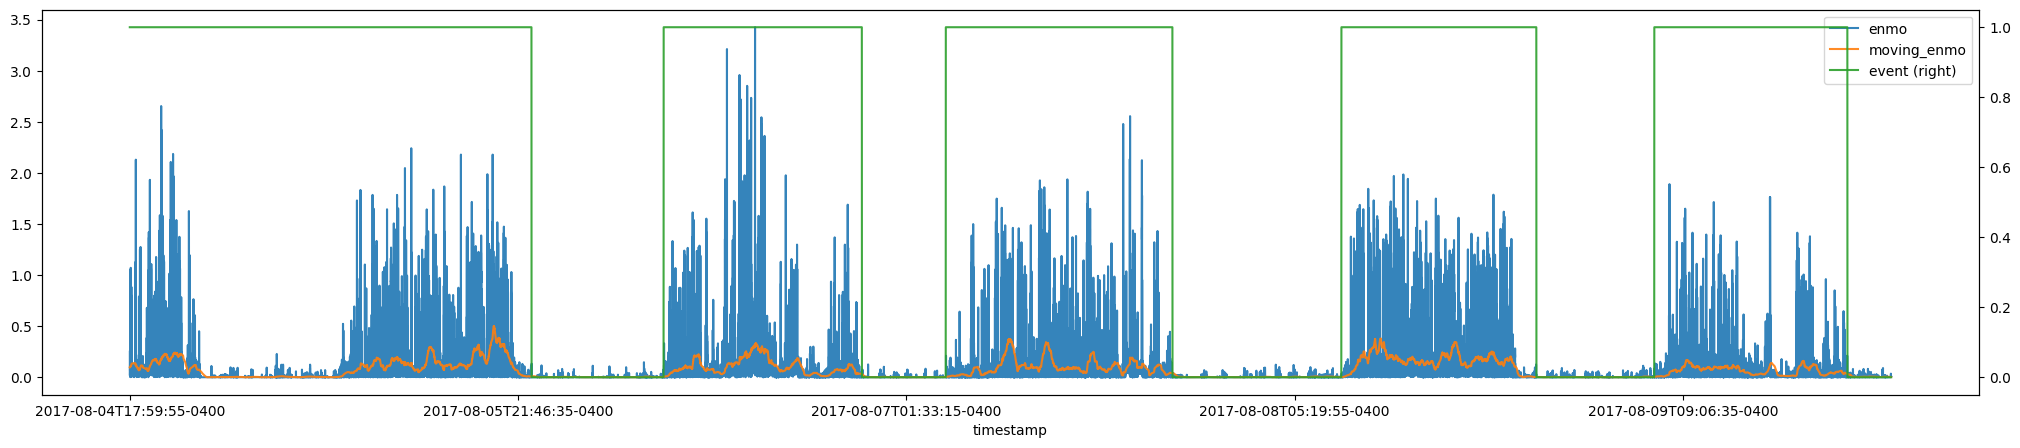

In [156]:
tmp.query("timestamp <'2017-08-10'").set_index("timestamp")[[ "enmo","moving_enmo","event"]].plot(alpha=0.9, secondary_y=["event"], figsize=(25,5))

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

(0.0, 0.5)

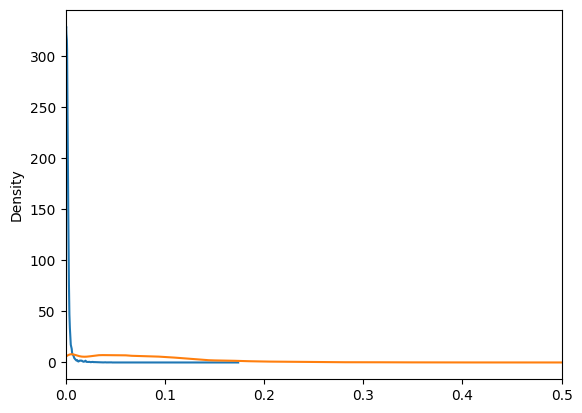

In [155]:
tmp.query("event==0").moving_enmo.plot.density()
tmp.query("event==1").moving_enmo.plot.density()
plt.xlim(0, 0.5)

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

(0.0, 0.5)

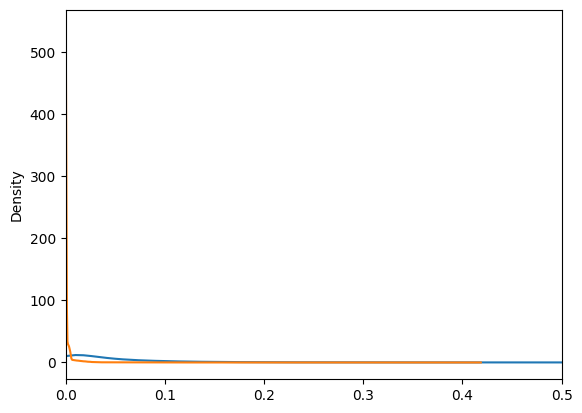

In [145]:
tmp.query("event==0").enmo.plot.density()
tmp.query("event==1").enmo.plot.density()
plt.xlim(0, 0.5)

In [146]:
tmp["mult"] = tmp["enmo"]*tmp["anglez"]

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

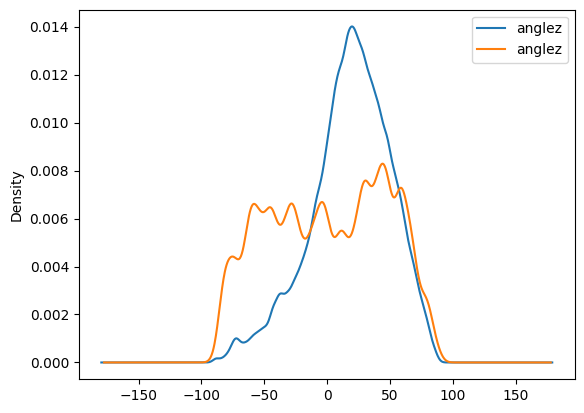

In [147]:
tmp.query("event==0").anglez.plot.density()
tmp.query("event==1").anglez.plot.density()
plt.legend()

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

(-10.0, 10.0)

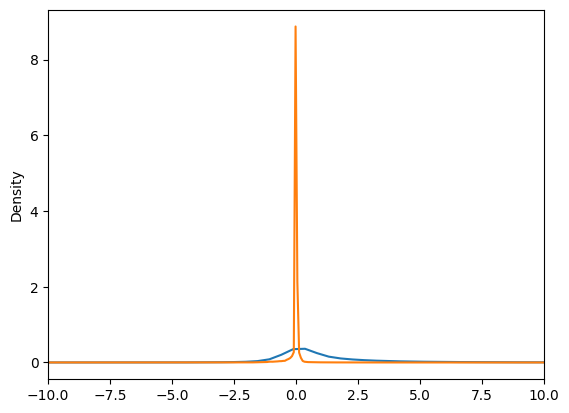

In [148]:
tmp.query("event==0").mult.plot.density()
tmp.query("event==1").mult.plot.density()
plt.xlim(-10,10)